<a href="https://colab.research.google.com/github/cristinaluna/ga-based_mapfusion/blob/main/MapFusionUsingGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map Fusion using GA

## Genetic Algorithms


## Simple method using overlap function


	 CASE 1 

 Generated maps

Generation 999: Best fitness = 0.6455
Best parameters (tx, ty, theta) (Generated Maps): [ 49.86418915  43.30300379 -44.9855548 ]
Best parameters: [ 49.86418915  43.30300379 -44.9855548 ]
Fused map: (293, 299)


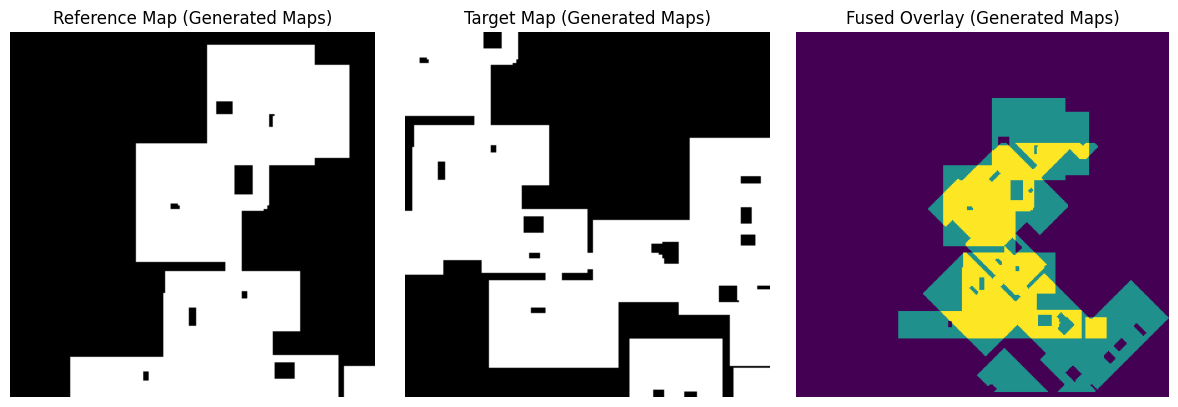


 Quite good, let's continue with the comparison!

Cross-Correlation params (Generated Maps): [ -40 -187    0]
RANSAC params (Generated Maps): [139.28956795  79.13623931 153.37011882]


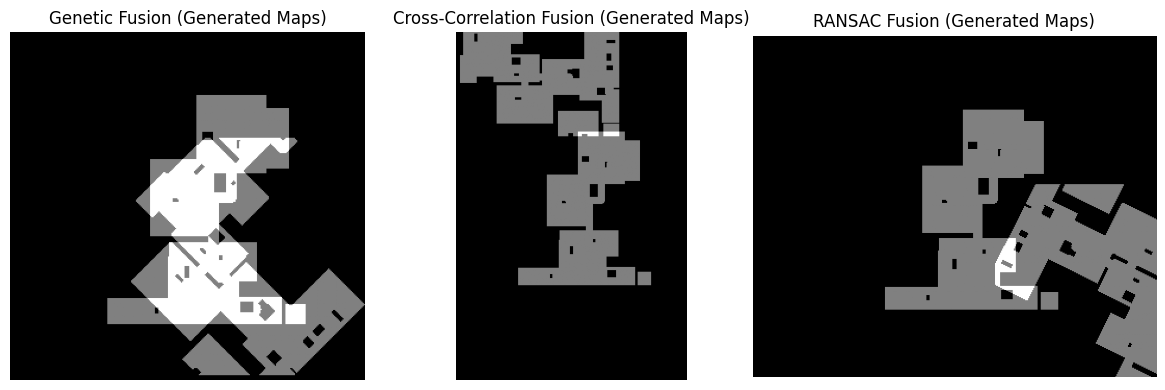


	 CASE 2 

 Real Robot Maps 1

Stopping early at generation 30 with fitness 0.8118
Generation 30: Best fitness = 0.8118
Best parameters (tx, ty, theta) (General 1): [290.28082843  -1.20185822   0.30126287]
Best parameters: [290.28082843  -1.20185822   0.30126287]
Fused map: (858, 1079)


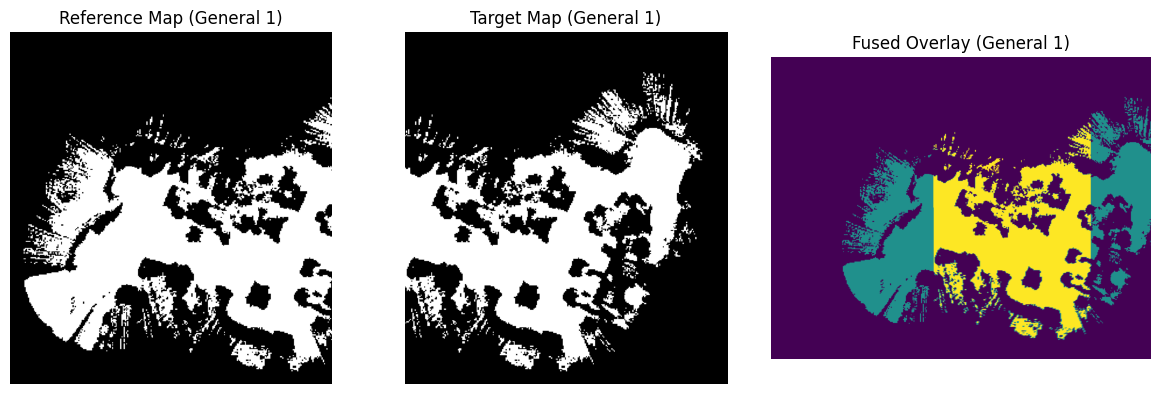


	 CASE 3 

 Real Robot Maps 2



In [ ]:
import numpy as np
import random
import cv2 as cv
from scipy.ndimage import rotate, sobel, binary_dilation
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
from skimage.transform import AffineTransform, warp
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from PIL import Image
from IPython.display import display
%matplotlib inline

class GeneticMapFusion:
    def __init__(self, ref_map, target_map, max_generations = 100, pop_size=20, generations=40,
                 mutation_std=(4, 4, 4), elite_size=3, selection_pool=10):
        self.ref_map = ref_map
        self.target_map = target_map
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_std = np.array(mutation_std)
        self.elite_size = elite_size
        self.selection_pool = selection_pool
        self.max_generations = max_generations

    def edge_weighted_iou(self, ref, target):
        # Edge dilatation using sobel
        ref_processed = binary_dilation(ref.astype(bool))
        target_processed = binary_dilation(target.astype(bool))

        ref_edges = sobel(ref_processed.astype(float)).astype(bool)
        target_edges = sobel(target_processed.astype(float)).astype(bool)

        intersection = np.logical_and(ref_edges, target_edges).sum()
        union = np.logical_or(ref_edges, target_edges).sum()

        return intersection / union if union > 0 else 0

    def evaluate_fitness(self, individual): # using ncc instead of IoU since it is more robust for non-fully-coincident maps
        tx, ty, theta = individual
        rotated = rotate(self.target_map, theta, reshape=False, order=1, mode='constant', cval=0)

        canvas_h = self.ref_map.shape[0] * 3
        canvas_w = self.ref_map.shape[1] * 3
        ref_canvas = np.zeros((canvas_h, canvas_w), dtype=np.uint8)
        target_canvas = np.zeros_like(ref_canvas)

        center_y, center_x = canvas_h // 2, canvas_w // 2

        y_ref = center_y - self.ref_map.shape[0] // 2
        x_ref = center_x - self.ref_map.shape[1] // 2
        ref_canvas[y_ref:y_ref + self.ref_map.shape[0], x_ref:x_ref + self.ref_map.shape[1]] = self.ref_map

        y_shift = center_y - rotated.shape[0] // 2 + int(round(ty))
        x_shift = center_x - rotated.shape[1] // 2 + int(round(tx))

        y_start = np.clip(y_shift, 0, canvas_h)
        x_start = np.clip(x_shift, 0, canvas_w)
        y_end = np.clip(y_shift + rotated.shape[0], 0, canvas_h)
        x_end = np.clip(x_shift + rotated.shape[1], 0, canvas_w)

        ry1 = np.clip(-y_shift, 0, rotated.shape[0])
        rx1 = np.clip(-x_shift, 0, rotated.shape[1])
        ry2 = ry1 + (y_end - y_start)
        rx2 = rx1 + (x_end - x_start)

        if any(val <= 0 for val in [y_end - y_start, x_end - x_start, ry2 - ry1, rx2 - rx1]):
            return 0

        try:
            target_canvas[y_start:y_end, x_start:x_end] = rotated[ry1:ry2, rx1:rx2]
        except ValueError:
            return 0

        region_ref = ref_canvas[y_start:y_end, x_start:x_end]
        region_target = target_canvas[y_start:y_end, x_start:x_end]

        if region_ref.shape != region_target.shape:
            return 0

        numerator = np.sum(region_ref * region_target)
        denominator = np.sqrt(np.sum(region_ref ** 2) * np.sum(region_target ** 2))
        score = numerator / denominator if denominator > 0 else 0

        if self.generations == 0:
            print(f"Initial fitness score: {score:.4f} for params {individual}")

        return score

    def generate_initial_population(self, tx_range, ty_range, theta_range):
        return [np.array([
            random.uniform(*tx_range),
            random.uniform(*ty_range),
            random.uniform(*theta_range)
        ]) for _ in range(self.pop_size)]

    def evolve(self, tx_range=(-20, 20), ty_range=(-20, 20), theta_range=(-15, 15), fitness_threshold=0.80, min_generations=30, max_generations=1000):
        if tx_range is None:
            tx_range = (-self.ref_map.shape[1], self.ref_map.shape[1])
        if ty_range is None:
            ty_range = (-self.ref_map.shape[0], self.ref_map.shape[0])

        population = self.generate_initial_population(tx_range, ty_range, theta_range)
        best_fitness = -np.inf
        best_individual = None

        for gen in range(max_generations):
            fitness_scores = [self.evaluate_fitness(ind) for ind in population]
            gen_best = max(fitness_scores)
            gen_best_ind = population[np.argmax(fitness_scores)]

            if gen_best > best_fitness:
                best_fitness = gen_best
                best_individual = gen_best_ind

            #print(f"Generation {gen}: Best fitness = {gen_best:.4f}")

            # Stop early if above threshold and min generations completed
            if best_fitness >= fitness_threshold and gen >= min_generations:
                print(f"Stopping early at generation {gen} with fitness {best_fitness:.4f}")
                break

            # Elitism: keep top individuals
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda p: -p[0])]
            new_population = sorted_population[:self.elite_size]

            while len(new_population) < self.pop_size:
                parents = random.sample(sorted_population[:self.selection_pool], 2)
                mutation_scale = self.mutation_std * (1 - gen / max_generations)

                child = (parents[0] + parents[1]) / 2
                mutation = np.random.normal(loc=0, scale=mutation_scale)

                if gen % 5 == 0 and random.random() < 0.3:
                    mutation += np.random.normal(loc=0, scale=self.mutation_std * 0.5)
                if random.random() < 0.1:
                    param_idx = np.random.randint(0, 3)
                    mutation[param_idx] += np.random.normal(loc=0, scale=self.mutation_std[param_idx] * 2)

                child += mutation
                new_population.append(child)

            population = new_population

        print(f"Generation {gen}: Best fitness = {gen_best:.4f}")
        return best_individual

    def fuse_maps_aligned(self, best_params):
        # Fuse maps using the best transformation parameters found
        tx, ty, theta = best_params
        rotated = rotate(self.target_map, theta, reshape=False, order=1, mode='constant', cval=0)

        ref_h, ref_w = self.ref_map.shape
        rot_h, rot_w = rotated.shape

        # Create canvas large enough to contain both maps
        canvas_h = max(ref_h, rot_h + abs(int(ty))) + 50
        canvas_w = max(ref_w, rot_w + abs(int(tx))) + 50
        canvas = np.zeros((canvas_h, canvas_w), dtype=np.uint8)

        # Place reference map
        y_offset = canvas_h // 2 - ref_h // 2
        x_offset = canvas_w // 2 - ref_w // 2
        canvas[y_offset:y_offset + ref_h, x_offset:x_offset + ref_w] = self.ref_map

        # Place transformed target map
        shifted_y = y_offset + int(round(ty))
        shifted_x = x_offset + int(round(tx))
        target_canvas = np.zeros_like(canvas)

        y_start = np.clip(shifted_y, 0, canvas_h)
        x_start = np.clip(shifted_x, 0, canvas_w)
        y_end = np.clip(shifted_y + rot_h, 0, canvas_h)
        x_end = np.clip(shifted_x + rot_w, 0, canvas_w)

        crop_y1 = np.clip(-shifted_y, 0, rot_h)
        crop_x1 = np.clip(-shifted_x, 0, rot_w)
        crop_y2 = crop_y1 + (y_end - y_start)
        crop_x2 = crop_x1 + (x_end - x_start)

        if (crop_y2 > crop_y1) and (crop_x2 > crop_x1):
            try:
                target_canvas[y_start:y_end, x_start:x_end] = rotated[crop_y1:crop_y2, crop_x1:crop_x2]
            except ValueError:
                pass

        fused_map = np.where((canvas == 1) & (target_canvas == 1), 1,
                     np.where((canvas == 1) | (target_canvas == 1), 0.5, 0))

        return fused_map, canvas, target_canvas

# ----------------- COMPARISON WITH OTHER METHODS --------

    # aligning using cross correlation
    def align_with_cross_correlation(self):
        correlation = correlate2d(self.ref_map, self.target_map, mode='full')
        max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)
        shift_y = max_idx[0] - self.target_map.shape[0] + 1
        shift_x = max_idx[1] - self.target_map.shape[1] + 1

        return np.array([shift_x, shift_y, 0])

    # aligning using ORB descriptors and RANSAC
    def align_with_ransac(self):
        kp_detector = cv.ORB_create(500)
        matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

        # ORB needs uint8 images
        ref_uint8 = (self.ref_map * 255).astype(np.uint8)
        target_uint8 = (self.target_map * 255).astype(np.uint8)

        kp1, des1 = kp_detector.detectAndCompute(ref_uint8, None)
        kp2, des2 = kp_detector.detectAndCompute(target_uint8, None)

        if des1 is None or des2 is None or len(kp1) < 5 or len(kp2) < 5:
            print("Insufficient keypoints for RANSAC.")
            return np.array([0, 0, 0])

        matches = matcher.match(des1, des2)
        if len(matches) < 4:
            print("Not enough matches for RANSAC.")
            return np.array([0, 0, 0])

        src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)

        M, inliers = cv.estimateAffinePartial2D(src_pts, dst_pts, method=cv.RANSAC)
        if M is None:
            return np.array([0, 0, 0])

        tx = M[0, 2]
        ty = M[1, 2]
        angle = np.arctan2(M[1, 0], M[0, 0]) * 180 / np.pi  # radians to degrees

        return np.array([tx, ty, angle])


# ----------------- AUXILIARY FUNCTION ------------------
def generate_realistic_test_maps(map_size=(400, 400), submap_size=(200, 200), overlap_region=(120, 120)):
    """
    Generate a synthetic binary occupancy map composed of rectangular rooms connected
    via logical L-shaped corridors based on a minimum spanning tree. Each room contains 1–2 obstacles.
    """
    full_map = np.zeros(map_size, dtype=np.uint8)

    room_centers = []
    room_boxes = []

    num_rooms = 20

    # Create rooms with random size and position
    for _ in range(num_rooms):
        room_width = np.random.randint(30, 80)
        room_height = np.random.randint(30, 80)
        x = np.random.randint(0, map_size[1] - room_width)
        y = np.random.randint(0, map_size[0] - room_height)
        full_map[y:y + room_height, x:x + room_width] = 1
        cx = x + room_width // 2
        cy = y + room_height // 2
        room_centers.append((cx, cy))
        room_boxes.append(((x, y), (x + room_width, y + room_height)))

    # Add 1–2 obstacles inside each room
    for (top_left, bottom_right) in room_boxes:
        x_min, y_min = top_left
        x_max, y_max = bottom_right

        num_obstacles = np.random.randint(1, 3)
        for _ in range(num_obstacles):
            obs_w = np.random.randint(5, 15)
            obs_h = np.random.randint(5, 15)
            obs_x = np.random.randint(x_min + 2, x_max - obs_w - 2)
            obs_y = np.random.randint(y_min + 2, y_max - obs_h - 2)
            full_map[obs_y:obs_y + obs_h, obs_x:obs_x + obs_w] = 0  # Clear area to create obstacle

    # Compute minimum spanning tree from room centers
    pts = np.array(room_centers)
    dist_matrix = distance_matrix(pts, pts)
    mst = minimum_spanning_tree(dist_matrix).toarray().astype(bool)

    # Draw L-shaped corridors for MST connections
    for i in range(num_rooms):
        for j in range(num_rooms):
            if mst[i, j]:
                x1, y1 = room_centers[i]
                x2, y2 = room_centers[j]
                cv.line(full_map, (x1, y1), (x2, y1), 1, thickness=5)
                cv.line(full_map, (x2, y1), (x2, y2), 1, thickness=5)

    # Apply dilation to simulate wall thickness
    kernel = np.ones((3, 3), np.uint8)
    full_map = cv.dilate(full_map, kernel, iterations=1)

    # Define submap positions with overlap
    y1, x1 = 0, 0
    y2 = submap_size[0] - overlap_region[0]
    x2 = submap_size[1] - overlap_region[1]

    map1 = full_map[y1:y1 + submap_size[0], x1:x1 + submap_size[1]]
    map2 = full_map[y2:y2 + submap_size[0], x2:x2 + submap_size[1]]

    return map1, map2

def run_fusion(ref_map, target_map, max_generations, title_suffix=","):

    plt.close('all')
    gmf = GeneticMapFusion(ref_map, target_map, max_generations, pop_size=30, generations=30, mutation_std=(4, 4, 4))
    w, h = ref_map.shape[1], ref_map.shape[0]
    best_params = gmf.evolve(tx_range=(-w, w), ty_range=(-h, h), theta_range=(-15, 15))
    print(f"Best parameters (tx, ty, theta) {title_suffix}:", best_params)

    fused_map, ref_canvas, target_canvas = gmf.fuse_maps_aligned(best_params)

    plt.figure(figsize=(12, 4))

    # 1. Reference Map
    plt.subplot(1, 3, 1)
    plt.title(f"Reference Map {title_suffix}")
    plt.imshow(ref_map, cmap='gray')
    plt.axis('off')

    # 2. Target Map
    plt.subplot(1, 3, 2)
    plt.title(f"Target Map {title_suffix}")
    plt.imshow(target_map, cmap='gray')
    plt.axis('off')

    # 3. Fused Overlay (RGB)
    plt.subplot(1, 3, 3)
    plt.title(f"Fused Overlay {title_suffix}")

    print(f"Best parameters: {best_params}")
    print(f"Fused map: {fused_map.shape}")

    plt.imshow(fused_map)
    plt.axis('off')
    plt.tight_layout()
    plt.show(block=False)
    plt.close('all')

    if title_suffix == "(Generated Maps)":
        print("\n Quite good, let's continue with the comparison!\n") # yes, it's support and debug

        # now with cross crorrelation and orb+ransac
        cc_params = gmf.align_with_cross_correlation()
        print(f"Cross-Correlation params {title_suffix}:", cc_params)

        ransac_params = gmf.align_with_ransac()
        print(f"RANSAC params {title_suffix}:", ransac_params)

        fused_cc, _, _ = gmf.fuse_maps_aligned(cc_params)
        fused_ransac, _, _ = gmf.fuse_maps_aligned(ransac_params)

        plt.figure(figsize=(12, 4))

        # Normalise maps
        def safe_display(img, title):
            if img.ndim == 3:
                img = img.astype(np.float32)
                if img.max() > 1.0:
                    img /= 255.0
                plt.imshow(img)
            else:
                plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')

        plt.subplot(1, 3, 1)
        safe_display(fused_map, f"Genetic Fusion {title_suffix}")

        plt.subplot(1, 3, 2)
        safe_display(fused_cc, f"Cross-Correlation Fusion {title_suffix}")

        plt.subplot(1, 3, 3)
        safe_display(fused_ransac, f"RANSAC Fusion {title_suffix}")

        plt.tight_layout()
        plt.show()


# ----------------- USAGE EXAMPLE ------------------
if __name__ == "__main__":

    print("\n\t CASE 1 \n\n Generated maps\n")
    # Case 1: using generated maps
    ref_map, target_map = generate_realistic_test_maps()
    run_fusion(ref_map, target_map, 1000, title_suffix="(Generated Maps)")


    print("\n\t CASE 2 \n\n Real Robot Maps 1\n")
    # Case 2: using real robot maps general_1_1.png y general_1_2.png
    ref_map = cv.imread("general_1_1.png", cv.IMREAD_GRAYSCALE)
    target_map = cv.imread("general_1_2.png", cv.IMREAD_GRAYSCALE)

    ref_map = (ref_map > 127).astype(np.uint8)
    target_map = (target_map > 127).astype(np.uint8)

    run_fusion(ref_map, target_map, 100, title_suffix="(General 1)")

    print("\n\t CASE 3 \n\n Real Robot Maps 2\n")
    # Case 3: using real robot maps general_2_1.png y general_2_2.png

    ref_map = cv.imread("general_2_1.png", cv.IMREAD_GRAYSCALE)
    target_map = cv.imread("general_2_2.png", cv.IMREAD_GRAYSCALE)

    ref_map = (ref_map > 127).astype(np.uint8)
    target_map = (target_map > 127).astype(np.uint8)

    run_fusion(ref_map, target_map, 40, title_suffix="(General 2)")